In [1]:
import pandas as pd
from google.colab import files

file = files.upload()
data = pd.read_csv('StudentPerformance.csv')

Saving StudentPerformance.csv to StudentPerformance.csv


**Exploratory Data Analysis**

In [14]:
data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [3]:
data.sample()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
5122,4,89,No,7,4,73.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [5]:
data.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [6]:
data.isnull().sum()

,0
Hours Studied,0
Previous Scores,0
Extracurricular Activities,0
Sleep Hours,0
Sample Question Papers Practiced,0
Performance Index,0


In [7]:
data.nunique()

,0
Hours Studied,9
Previous Scores,60
Extracurricular Activities,2
Sleep Hours,6
Sample Question Papers Practiced,10
Performance Index,91


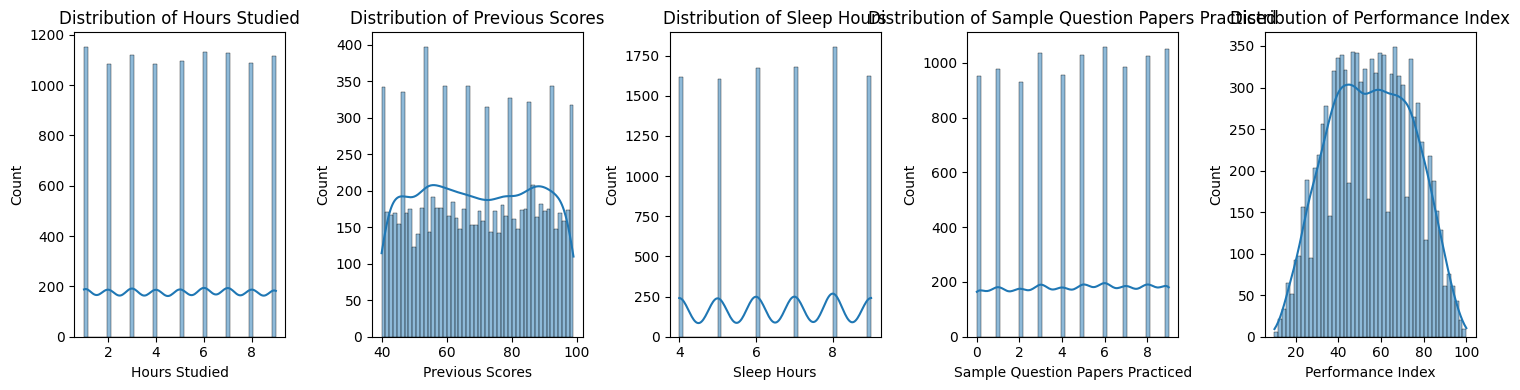

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = ['Hours Studied','Previous Scores','Sleep Hours',
        'Sample Question Papers Practiced','Performance Index']

plt.figure(figsize=(15,4))

for i,col in enumerate(cols,1):
  plt.subplot(1,5,i)
  sns.histplot(data[col],bins=50,kde=True)
  plt.title(f'Distribution of {col}')


plt.tight_layout()
plt.show()

*There are no empty columns, and there are no other anomalies in the data, so we can skip data cleaning and move on to the data split stage.*

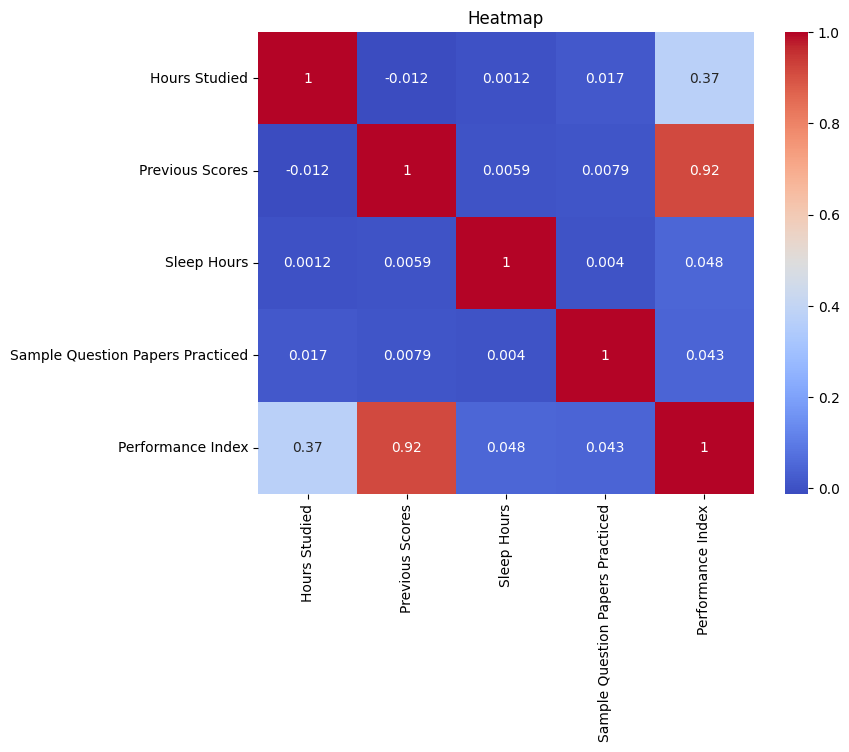

In [21]:
map = data.drop(columns = ["Extracurricular Activities"]).corr()

plt.figure(figsize=(8,6))
sns.heatmap(map,annot=True,cmap="coolwarm")
plt.title("Heatmap")
plt.show()

**Split Data**

In [9]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='Performance Index')
y = data['Performance Index']

TrainX,ValX,TrainY,ValY = train_test_split(
    X,y,test_size=0.3,random_state=42
)

numeric_features = TrainX.select_dtypes(include=['int64','float64']).columns
categorical_features = TrainX.select_dtypes(include=['object']).columns


TrainX.shape, ValX.shape

((7000, 5), (3000, 5))

**Preprocessing Pipeline**

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn.preprocessing import OrdinalEncoder

numeric_transform = Pipeline(steps=[
    ('Scaler',StandardScaler())
])

categorical_transform = Pipeline(steps=[
    ('ordinal',OrdinalEncoder(categories=[['No','Yes']]))
])

In [11]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_transform,numeric_features),
        ('cat',categorical_transform,categorical_features)
    ]

)


**Mutual Information**

In [12]:
from sklearn.feature_selection import mutual_info_regression

TrainXMI = preprocessor.fit_transform(TrainX)

name = list(numeric_features) + list(categorical_features)

mi_scores = mutual_info_regression(
    TrainXMI,TrainY,random_state=42
)

mi_series = pd.Series(mi_scores,index=name)
mi_series = mi_series.sort_values(ascending=False)

mi_series

,0
Previous Scores,0.931743
Hours Studied,0.162866
Sleep Hours,0.011652
Sample Question Papers Practiced,0.001808
Extracurricular Activities,0.000000


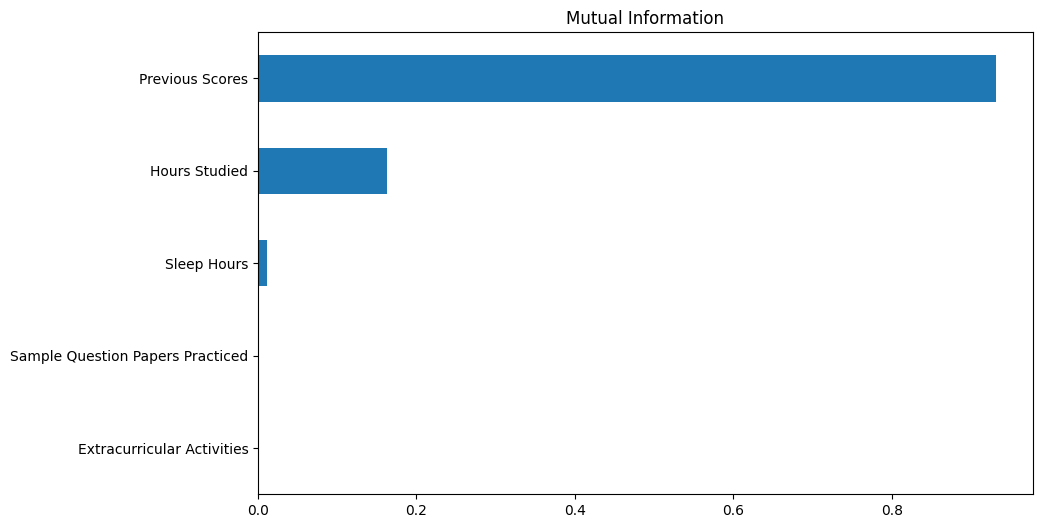

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
mi_series.head(5).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Mutual Information")

plt.show()

*Previous Scores has the biggest score compared to other features and in second place is Hour Studied, both of these features hv a strong relationship with the target*

**Baseline Model**

In [24]:
from sklearn.linear_model import LinearRegression

linreg_model = Pipeline(steps=[
    ("preprocessor",preprocessor),
    ("model", LinearRegression())
])

In [23]:
from sklearn.model_selection import cross_val_score

rmse_score = -cross_val_score(
    linreg_model,TrainX,TrainY,
    scoring = 'neg_root_mean_squared_error',
    cv = 5
)

print("RMSE of Linear Regression ")
print("Mean:", rmse_score.mean())
print("Std:", rmse_score.std())

RMSE of Linear Regression 
Mean: 2.04943925603626
Std: 0.04361562723770465


**Random Forest Model**

In [25]:
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline(steps=[
    ("preprocessor",preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,random_state=42,
        n_jobs=-1
    ))
])

In [27]:
rf_rmse = -cross_val_score(
    rf_model,TrainX,TrainY,
    scoring = 'neg_root_mean_squared_error',
    cv = 5
)

print("RMSE of Random Forest ")
print("Mean:", rf_rmse.mean())
print("Std:", rf_rmse.std())

RMSE of Random Forest 
Mean: 2.3494074386671526
Std: 0.053733527022634085


*After modelling on a linear model(linear regression) and a non linear model(random forest), the linear model has a score that is relatively much smaller than the non linear mode, which means that this data has a linear/almost linear relationship, bcs when checking the relationship between features and targets, there is one feature that has a relatively large value(0.9)*

**Linear Model**

In [29]:
from sklearn.linear_model import Ridge

Ridge_model = Pipeline(steps=[
    ("preprocessor",preprocessor),
    ("model", Ridge(alpha=1.0))
])

In [30]:
ridge_rmse = -cross_val_score(
    Ridge_model,TrainX,TrainY,
    scoring = "neg_root_mean_squared_error",
    cv = 5
)

print("RMSE of Ridge ")
print("Mean:", ridge_rmse.mean())
print("Std:", ridge_rmse.std())

RMSE of Ridge 
Mean: 2.049444626740276
Std: 0.0435037896578685


*Linear Regression and Ridge Regression gave nearly identical performance (RMSE = 2.05), indicating that the data has a predominantly linear relationship with low noise and Regularization does not provide significant improvement.*

**Final Model**

*We chose linear regression as the final model, because it has an rmse score of 2.05, which means it is off by about 2 points from the range 0 - 100.*

In [32]:
from sklearn.metrics import mean_squared_error
import numpy as np

linreg_model.fit(TrainX,TrainY)
y_pred = linreg_model.predict(ValX)

rmse = np.sqrt(mean_squared_error(ValY,y_pred))
print("RMSE:", rmse)

RMSE: 2.0165722957763466


In [35]:
from sklearn.metrics import mean_absolute_error,r2_score

mae = mean_absolute_error(ValY,y_pred)
r2 = r2_score(ValY,y_pred)

print("R2:", r2)
print("mae:",mae)

R2: 0.9890110607021136
mae: 1.6090437564045224


*The Linear Regression model showed excellent performance with an R² of 0.989 and an MAE of around 1.6, indicating accurate and stable predictive capabilities.*

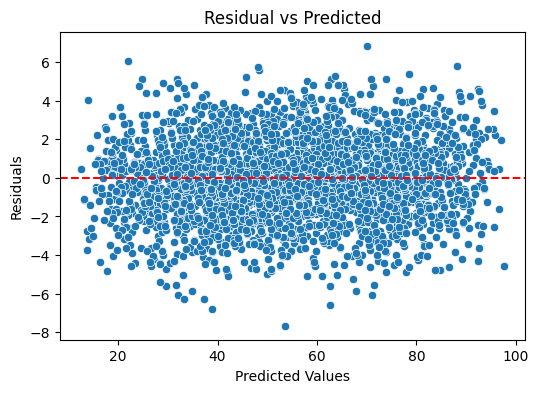

In [44]:
y_pred = linreg_model.predict(ValX)
residuals = ValY - y_pred

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual vs Predicted")
plt.show()

*The residual plot shows a random distribution around zero with no particular pattern, indicating that the assumptions of linearity and homoscedasticity are met. This supports the use of Linear Regression as an appropriate model.*

In [50]:
linreg_model.fit(TrainX,TrainY)

important_features = linreg_model.named_steps['model'].coef_

feature_names = list(numeric_features) + list(categorical_features)

feature_important_linreg = pd.Series(important_features,index=feature_names).sort_values(
    ascending = False
)

feature_important_linreg.head()


,0
Previous Scores,17.608273
Hours Studied,7.422770
Sleep Hours,0.813870
Extracurricular Activities,0.581713
Sample Question Papers Practiced,0.545983


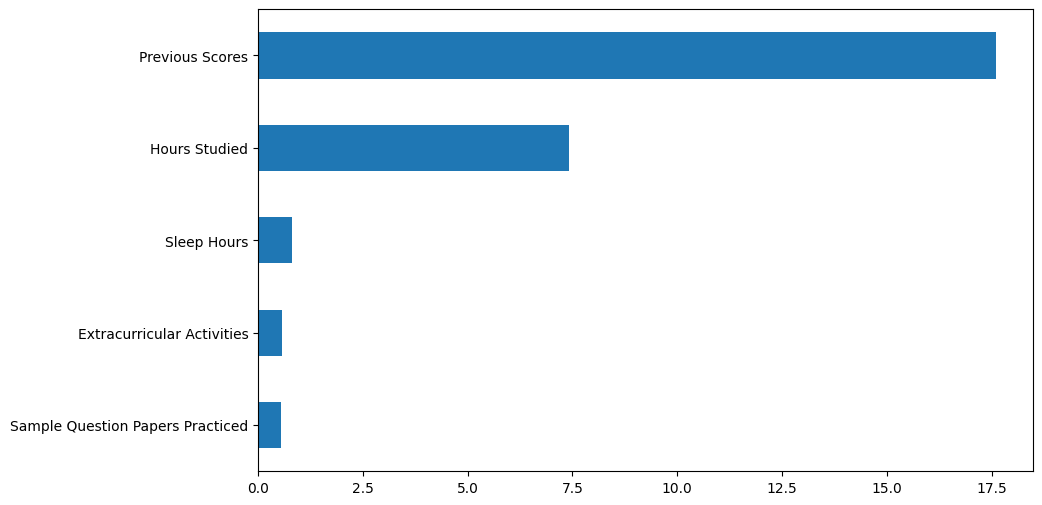

<Figure size 640x480 with 0 Axes>

In [51]:
plt.figure(figsize=(10,6))
feature_important_linreg.head().plot(kind='barh')
plt.gca().invert_yaxis()
plt.figure("top 5 feature importances linear regression")
plt.show()

*The model coefficients show that Previous Scores are the most dominant factor in predicting the Performance Index, followed by Hours Studied. Other variables have a positive but relatively small influence*

**Model Interface**

In [61]:
import joblib

joblib.dump(linreg_model, "linreg_model.pkl")
model = joblib.load("linreg_model.pkl")

In [73]:
new_student = {
    "Hours Studied": 12,
    "Previous Scores": 90,
    "Sleep Hours": 9,
    "Extracurricular Activities": "Yes",
    "Sample Question Papers Practiced": 1
}

In [74]:
def predict_performance(model, student_dict, reference_columns):
    df = pd.DataFrame(columns=reference_columns)
    df.loc[0] = student_dict
    return model.predict(df)[0]

pred = predict_performance(
    model,
    new_student,
    TrainX.columns
)

print(f"Predicted Performance Index: {pred:.2f}")


Predicted Performance Index: 96.96
